In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def load_data(url):
    source_df = pd.read_csv(url, na_values=" ", keep_default_na=True)
    return source_df

In [7]:
def data_preprocess(df):
    #   Смотрим типы данных столбцов
    print("Предварительная информация о данных:")
    print(df.shape)
    print(df.info())
    print(df.head(10))

    #   Метрики качества данных
    quality_metrics = evaluate_data_quality(df)
    print("Метрики качества данных:")
    for key, value in quality_metrics.items():
        print(f"{key}: {value}")

    #   Если есть удаляем пустые значения
    if df.isnull().any(axis=1).sum() > 0:
        df = df.dropna()

    #   Если есть удаляем дубликаты
    if df.duplicated().sum() > 0:
        df = df.drop_duplicates()

    #   Обрабатываем выбросы
    df = del_outliers(df)

    #   Преобразуем столбцы типа object в int8 (кодируем категориальные данные)
    cat_columns = df.select_dtypes(["object"]).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.astype("category"))
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

    #   Возвращаем обработанный датайфрем
    return df

In [8]:
#   Функция для показа метрик качества данных
def evaluate_data_quality(df):
    metrics = {
        "Общее количество строк": len(df),
        "Количество столбцов": len(df.columns),
        "Пропущенные значения (процент)": df.isnull().any(axis=1).sum()
        / (len(df) * len(df.columns))
        * 100,
        "Количество дубликатов": df.duplicated().sum(),
    }
    return metrics

In [9]:
#   Функция для обработки выбросов
def del_outliers(df):
    numeric_columns = df.select_dtypes(include=["number"]).columns
    for column in numeric_columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    print("\nВыбросы обработаны")
    return df

In [10]:
#   Присваиваем переменной результат вызванной функции
url = "Life-Expectancy-Data-Averaged.csv"
df = load_data(url)
df = data_preprocess(df)

Предварительная информация о данных:
(180, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Country                      180 non-null    object 
 1   Region                       180 non-null    object 
 2   Year                         180 non-null    float64
 3   Infant_deaths                180 non-null    float64
 4   Under_five_deaths            180 non-null    float64
 5   Adult_mortality              180 non-null    float64
 6   Alcohol_consumption          179 non-null    float64
 7   Hepatitis_B                  179 non-null    float64
 8   Measles                      180 non-null    float64
 9   BMI                          180 non-null    float64
 10  Polio                        180 non-null    float64
 11  Diphtheria                   180 non-null    float64
 12  Incidents_HIV                17

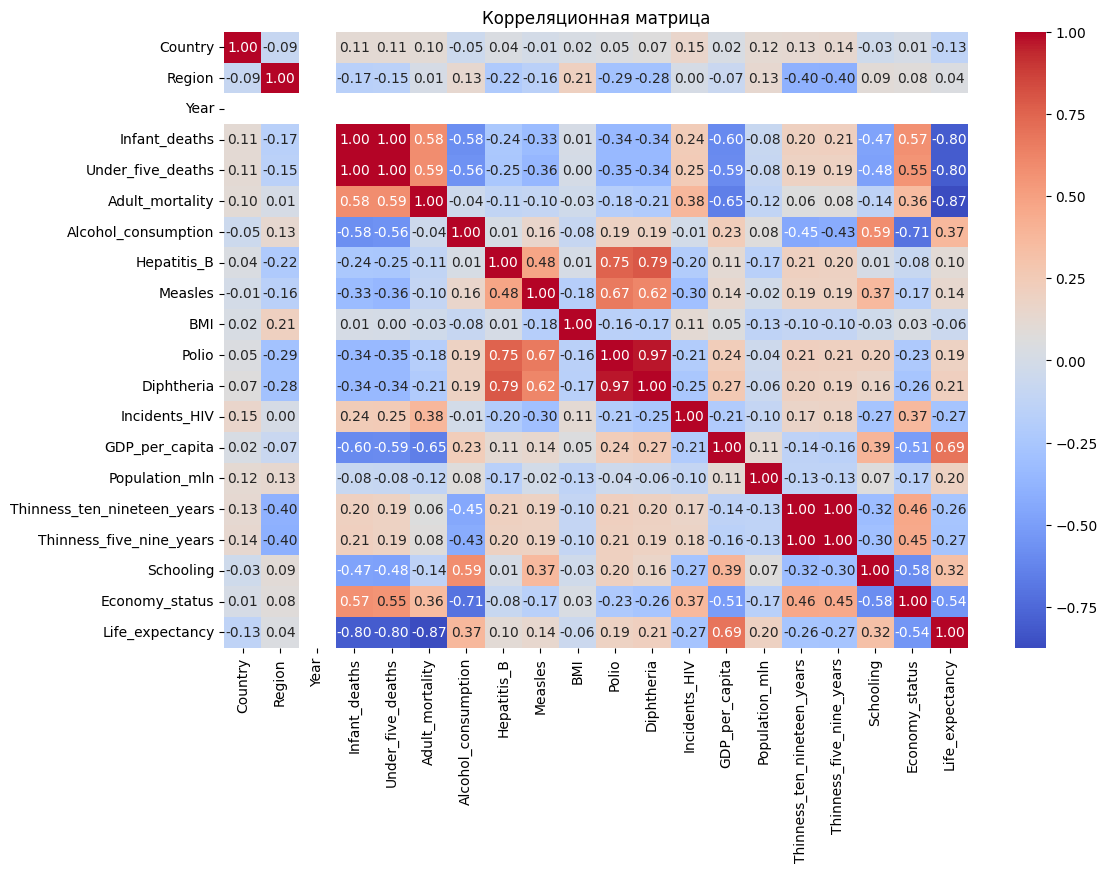

In [11]:
#   Корреляционный анализ
#   Корреляция между признаками
correlation_matrix = df.corr()

#   Визуализация корреляционной матрицы
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляционная матрица")
plt.show()

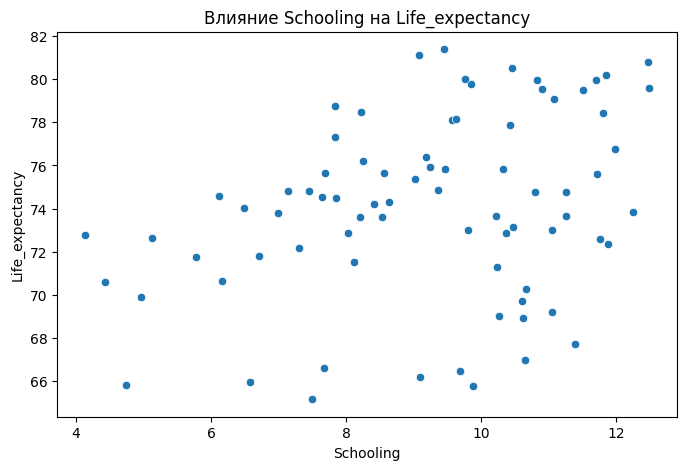

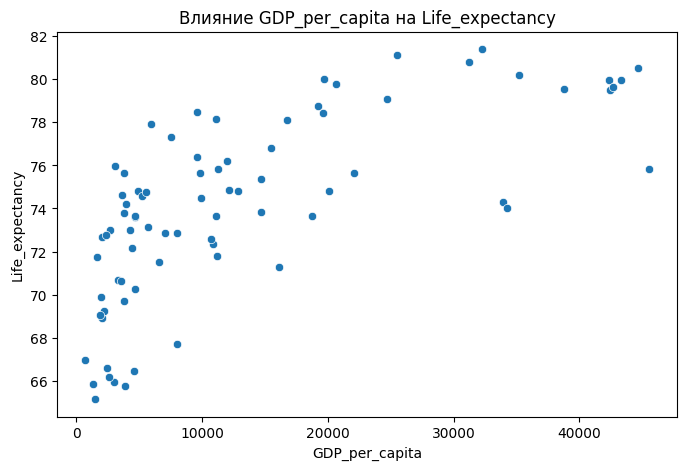

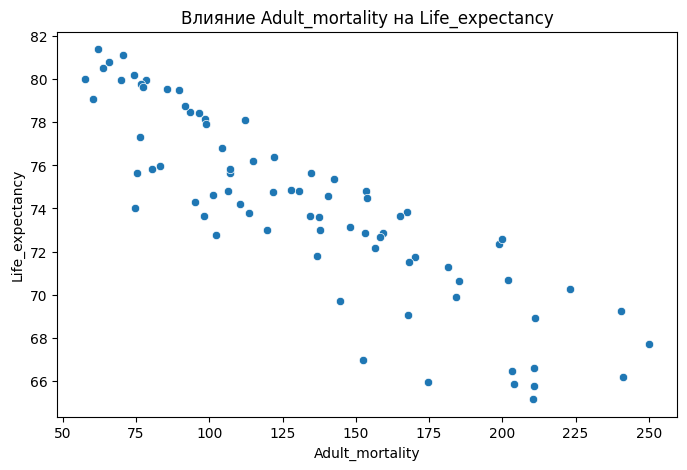

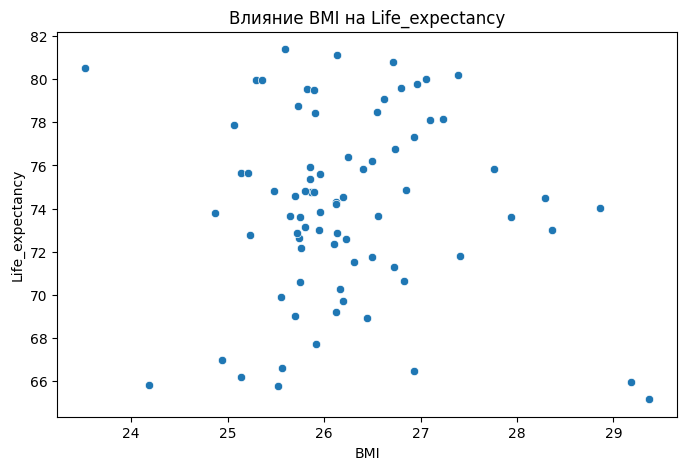

In [12]:
#   Графический анализ
#   Построим графики для признаков с наибольшей корелляцией
important_features = ["Schooling", "GDP_per_capita", "Adult_mortality", "BMI"]

for feature in important_features:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x=feature, y="Life_expectancy")
    plt.title(f"Влияние {feature} на Life_expectancy")
    plt.xlabel(feature)
    plt.ylabel("Life_expectancy")
    plt.show()

In [13]:
#   Определим числовые признаки
numerical_features = df.select_dtypes(include=["float64", "int64"]).columns

#   Масштабирование с помощью StandardScaler
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])


In [14]:
#   Построение модели
#   Разделим данные на обучающую и тестовую выборки:
#   Выбор признаков и целевой переменной
x = df.drop(columns=["Life_expectancy", "Country", "Region"])
y = df["Life_expectancy"]

#   Разделение на обучающую и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)
#   Обучим модели (Линейная регрессия и Случайный лес):
#   Линейная регрессия
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)
y_pred_linear = linear_model.predict(x_test)

#   Случайный лес
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(x_train, y_train)
y_pred_rf = rf_model.predict(x_test)

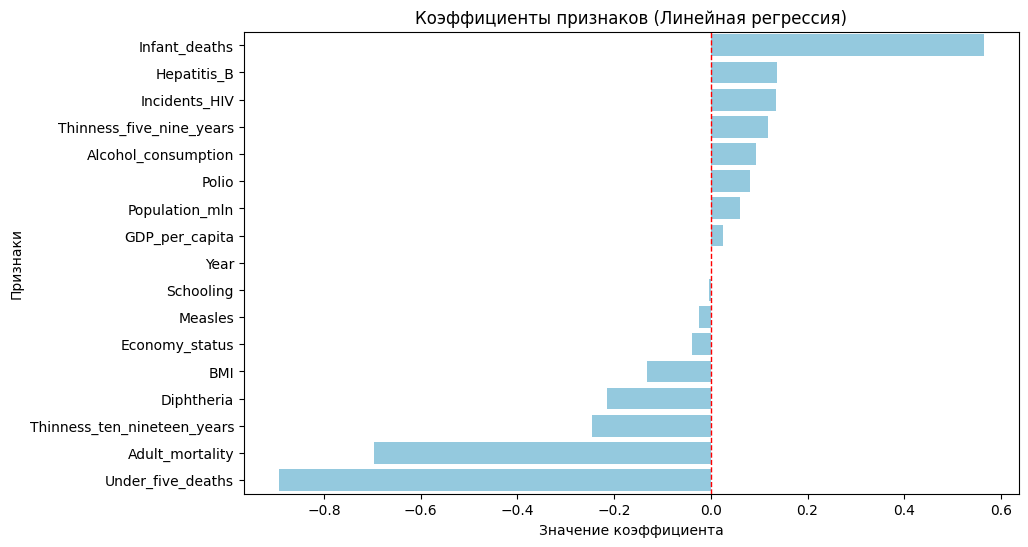

In [15]:
#   Визуализируем важность признаков линейной регрессии
# Получение коэффициентов линейной регрессии
linear_coefficients = pd.Series(linear_model.coef_, index=x.columns).sort_values(
    ascending=False
)

# Визуализация коэффициентов
plt.figure(figsize=(10, 6))
sns.barplot(x=linear_coefficients.values, y=linear_coefficients.index, color="skyblue")
plt.title("Коэффициенты признаков (Линейная регрессия)")
plt.xlabel("Значение коэффициента")
plt.ylabel("Признаки")
plt.axvline(0, color="red", linestyle="--", linewidth=1)  # Линия на нуле для ориентира
plt.show()

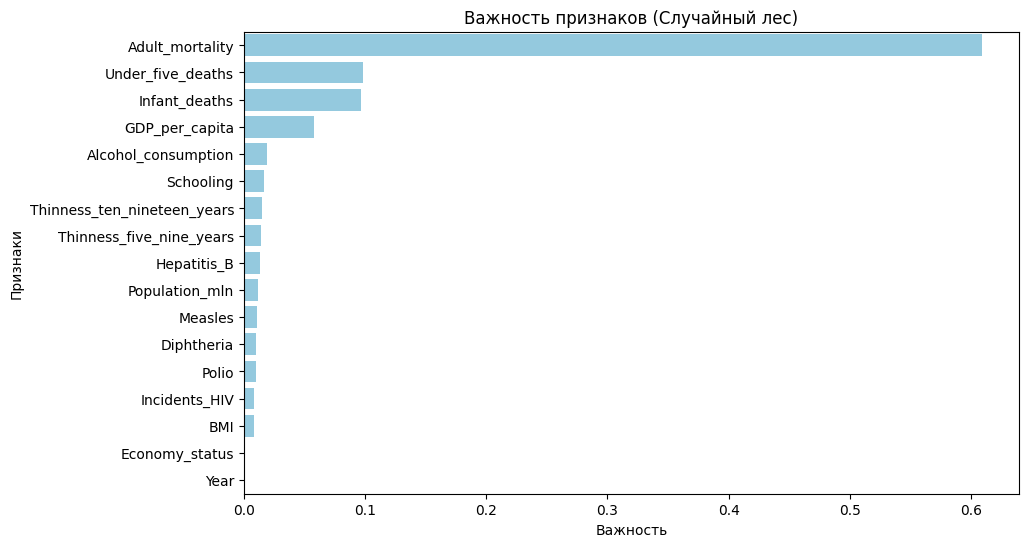

In [16]:
#   Визуализируем важность признаков для случайного леса:
#   Важность признаков
feature_importances = pd.Series(
    rf_model.feature_importances_, index=x.columns
).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index, color="skyblue")
plt.title("Важность признаков (Случайный лес)")
plt.xlabel("Важность")
plt.ylabel("Признаки")
plt.show()

In [17]:
#   Разработка базы данных
#   Создаем базу данных SQLite и сохраняем обработанный датафрейм
engine = create_engine("sqlite:///life_expectancy.db")
df.to_sql("life_expectancy_research", engine, index=False, if_exists="replace")
print("Данные сохранены в базу данных life_expectancy.db")

Данные сохранены в базу данных life_expectancy.db
